In [1030]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import joblib
import folium
from branca.colormap import LinearColormap
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.spatial.distance import cdist

In [1031]:
data = pd.read_csv('processed_data_by_zipcode.csv')
property_data = pd.read_csv('cleaned_property_data.csv')

model = joblib.load('rf_model/random_forest_model.pkl')
feature_names = model.feature_names_in_
le_type = joblib.load('rf_model/le_type.pkl')
le_zipcode = joblib.load('rf_model/le_zipcode.pkl')
le_borough = joblib.load('rf_model/le_borough.pkl')
le_neighborhood = joblib.load('rf_model/le_neighborhood.pkl')
cluster_centers = joblib.load('rf_model/cluster_centers.pkl')

In [1032]:
# Forgot to add borough
borough_info = property_data[['ZIPCODE', 'BOROUGH']].drop_duplicates()
data = data.merge(borough_info, left_on='ZipCode', right_on='ZIPCODE', how='left')
data.drop('ZIPCODE', axis=1, inplace=True)

In [1033]:
# User preference 
income_ranges = [
    "Under $50,000",
    "$50,000-$100,000",
    "$100,000-$150,000",
    "$150,000-$200,000",
    "Over $200,000",
    "Prefer not to say"
]

neighborhood_types = [
    "Quiet residential",
    "Balanced mix",
    "Lively urban",
    "No preference"
]

household_types = [
    "Mostly families",
    "Mix of families and singles",
    "Mostly singles",
    "No preference"
]

business_environments = [
    "Mostly residential",
    "Mix of residential and commercial",
    "Bustling commercial area",
    "No preference"
]

amenity_options = [
    "Parks and recreation",
    "Shopping and restaurants",
    "Schools and education",
    "Public transportation",
    "Cultural attractions"
]

In [1034]:
def get_user_preferences():
    preferences = {}
    preferences['borough'] = input("Enter preferred borough: ")
    preferences['max_price'] = float(input("Enter maximum price: "))
    preferences['house_type'] = input("Enter house type (e.g., Condo, House, Coop, Townhouse): ")
    preferences['bedrooms'] = int(input("Enter number of bedrooms: "))
    preferences['bathrooms'] = float(input("Enter number of bathrooms: "))
    
    print("\nIncome range options:")
    for i, option in enumerate(income_ranges, 1):
        print(f"{i}. {option}")
    income_choice = int(input("Select your income range (enter the number): ")) - 1
    preferences['income'] = income_ranges[income_choice]
    
    print("\nNeighborhood Liveliness options:")
    for i, option in enumerate(neighborhood_types, 1):
        print(f"{i}. {option}")
    neighborhood_choice = int(input("Select your preferred neighborhood type (enter the number): ")) - 1
    preferences['neighborhood_preference'] = neighborhood_types[neighborhood_choice]
    
    print("\nHousehold type options:")
    for i, option in enumerate(household_types, 1):
        print(f"{i}. {option}")
    household_choice = int(input("Select your preferred household type (enter the number): ")) - 1
    preferences['household_type'] = household_types[household_choice]
    
    print("\nBusiness environment options:")
    for i, option in enumerate(business_environments, 1):
        print(f"{i}. {option}")
    business_choice = int(input("Select your preferred business environment (enter the number): ")) - 1
    preferences['business_environment'] = business_environments[business_choice]
    
    print("\nAmenity options (you can select multiple):")
    for i, option in enumerate(amenity_options, 1):
        print(f"{i}. {option}")
    amenity_choices = input("Select your preferred amenities (enter numbers separated by commas): ")
    preferences['amenity_preferences'] = [amenity_options[int(choice)-1] for choice in amenity_choices.split(',')]
    
    return preferences

In [1035]:
def predict_price(zipcode, preferences, property_data, model):
    # Encode inputs
    type_encoded = le_type.transform([preferences['house_type']])[0]
    borough_encoded = le_borough.transform([preferences['borough']])[0]
    zipcode_encoded = le_zipcode.transform([zipcode])[0]
    
    zipcode_data = property_data[property_data['ZIPCODE'] == zipcode]
    
    if zipcode_data.empty:
        print(f"No data available for zipcode {zipcode}")
        return None
    
    median_lat = zipcode_data['LATITUDE'].median()
    median_lon = zipcode_data['LONGITUDE'].median()
    
    # Calculate distances to cluster centers
    distances = cdist([[median_lat, median_lon]], cluster_centers)[0]
    location_cluster = np.argmin(distances)
    
    neighborhood = zipcode_data['NEIGHBORHOOD'].mode()[0]
    neighborhood_encoded = le_neighborhood.transform([neighborhood])[0]
    
    input_data = pd.DataFrame({
        'BEDS': [int(preferences['bedrooms'])],
        'BATH': [float(preferences['bathrooms'])],
        'TYPE_ENCODED': [int(type_encoded)],
        'ZIPCODE_ENCODED': [int(zipcode_encoded)],
        'BOROUGH_ENCODED': [int(borough_encoded)],
        'NEIGHBORHOOD_ENCODED': [int(neighborhood_encoded)],
        'LOCATION_CLUSTER': [int(location_cluster)]
    })
    
    # Add distance features
    for i, distance in enumerate(distances):
        input_data[f'DISTANCE_TO_CLUSTER_{i}'] = [distance]
    
    prediction = model.predict(input_data)[0]
    return prediction

In [1036]:
def calculate_zipcode_score(zipcode_data, preferences):
    score = 0
    
    # Income score
    if preferences['income'] != "Prefer not to say":
        income_categories = ["Under $50,000", "$50,000-$100,000", "$100,000-$150,000", "$150,000-$200,000", "Over $200,000"]
        user_income_category = income_categories.index(preferences['income'])
        zipcode_income_category = ["Very Low", "Low", "Medium", "High", "Very High"].index(zipcode_data['IncomeCategory'])
        score += 0.2 * (1 - abs(user_income_category - zipcode_income_category) / 4)
    else:
        score += 0.2
    
    # Neighborhood preference score
    if preferences['neighborhood_preference'] != "No preference":
        neighborhood_types = {"Quiet residential": 0, "Balanced mix": 0.5, "Lively urban": 1}
        user_pref = neighborhood_types[preferences['neighborhood_preference']]
        score += 0.2 * (1 - abs(user_pref - zipcode_data['LivelinessScore']))
    else:
        score += 0.2
    
    # Household type preference score
    if preferences['household_type'] != "No preference":
        household_types = {"Mostly families": 1, "Mix of families and singles": 0.5, "Mostly singles": 0}
        user_pref = household_types[preferences['household_type']]
        score += 0.15 * (1 - abs(user_pref - zipcode_data['FamilyFriendlinessScore']))
    else:
        score += 0.15
    
    # Business environment score
    if preferences['business_environment'] != "No preference":
        business_env_types = {"Mostly residential": 0, "Mix of residential and commercial": 0.5, "Bustling commercial area": 1}
        user_pref = business_env_types[preferences['business_environment']]
        score += 0.15 * (1 - abs(user_pref - zipcode_data['BusinessEnvironmentScore']))
    else:
        score += 0.15
    
    # Amenities score
    amenity_columns = {
        "Parks and recreation": "recreational_facility_density",
        "Shopping and restaurants": "BusinessDensity",
        "Schools and education": "education_facility_density",
        "Public transportation": "transportation_facility_density",
        "Cultural attractions": "cultural_facility_density"
    }
    amenity_score = sum(zipcode_data[amenity_columns[pref]] for pref in preferences['amenity_preferences']) / len(preferences['amenity_preferences'])
    score += 0.15 * amenity_score
    
    # Safety and diversity scores
    score += 0.1 * zipcode_data['SafetyScore']
    score += 0.05 * zipcode_data['DiversityIndex']
    
    return score

In [1037]:
def get_recommended_zipcodes(data, preferences, property_data, model, n_recommendations=5):
    if 'BOROUGH' in data.columns:
        borough_data = data[data['BOROUGH'] == preferences['borough']]
    else:
        print("Warning: 'BOROUGH' information is missing. Considering all zipcodes.")
        borough_data = data
    
    recommended_areas = []
    for _, zipcode_data in borough_data.iterrows():
        zipcode = zipcode_data['ZipCode']
        price = predict_price(zipcode, preferences, property_data, model)
        
        if price is not None and price <= preferences['max_price']:
            score = calculate_zipcode_score(zipcode_data, preferences)
            recommended_areas.append((zipcode, price, score, zipcode_data))
    
    recommended_areas.sort(key=lambda x: x[2], reverse=True)
    return recommended_areas[:n_recommendations]

In [1038]:
def find_similar_zipcodes(data, preferred_zipcode, n_neighbors=5):
    # Select features
    features = ['LivelinessScore', 'FamilyFriendlinessScore', 'SafetyScore', 
                'BusinessEnvironmentScore', 'AmenityScore', 'DiversityIndex']
    
    # Prepare 
    X = data[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit KNN 
    knn = NearestNeighbors(n_neighbors=n_neighbors+1, metric='euclidean')
    knn.fit(X_scaled)
    
    # Find similar zipcodes
    preferred_zipcode_index = data[data['ZipCode'] == preferred_zipcode].index[0]
    distances, indices = knn.kneighbors(X_scaled[preferred_zipcode_index].reshape(1, -1))
    
    similar_zipcodes = data.iloc[indices[0][1:]]['ZipCode'].tolist()  
    return similar_zipcodes

In [1039]:
def cluster_zipcodes(data, n_clusters=5):
    # Select features for clustering
    features = data.select_dtypes(include=[np.number]).columns.tolist()
    features = [f for f in features if f not in ['ZipCode', 'Cluster']]
    
    # Prepare 
    X = data[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data['Cluster'] = kmeans.fit_predict(X_scaled)
    
    return data

In [1040]:
def create_map(recommended_areas, data):
    lats = [rec['latitude'] for _, _, _, rec in recommended_areas]
    lngs = [rec['longitude'] for _, _, _, rec in recommended_areas]
    center_lat = sum(lats) / len(lats)
    center_lng = sum(lngs) / len(lngs)

    m = folium.Map(location=[center_lat, center_lng], zoom_start=11)
    
    # Create a color map
    scores = [score for _, _, score, _ in recommended_areas]
    color_map = LinearColormap(colors=['red', 'yellow', 'green'], vmin=min(scores), vmax=max(scores))
    
    for i, (zipcode, price, score, rec) in enumerate(recommended_areas, 1):
        color = color_map(score)
        
        folium.CircleMarker(
            location=[rec['latitude'], rec['longitude']],
            radius=15,
            popup=f"Rank: {i}<br>Zipcode: {zipcode}<br>Predicted Price: ${price:,.2f}<br>Score: {score:.2f}",
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=0.7
        ).add_to(m)
    
    color_map.add_to(m)
    color_map.caption = 'Recommendation Score'
    
    return m

In [1041]:
def plot_zipcode_scores(recommended_areas, preferences):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    features = ['liveliness_score', 'family_friendliness', 'safety_score', 
                'business_environment', 'diversity_index']
    
    for i, (zipcode, _, _, rec) in enumerate(recommended_areas):
        scores = [rec[feature] for feature in features]
        ax.bar(np.arange(len(features)) + i*0.15, scores, width=0.15, label=f'Zipcode {zipcode}')
    
    ax.set_xticks(np.arange(len(features)) + 0.3)
    ax.set_xticklabels(features, rotation=45, ha='right')
    ax.set_ylabel('Score')
    ax.set_title('Feature Scores for Recommended Zipcodes')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [1042]:
def get_recommendations(preferences):
    global data, property_data, model

    # Cluster zipcodes if not already done
    if 'Cluster' not in data.columns:
        data = cluster_zipcodes(data)
    
    recommended_areas = get_recommended_zipcodes(data, preferences, property_data, model)
    
    recommendations = []
    for i, (zipcode, price, score, zipcode_data) in enumerate(recommended_areas, 1):
        similar_zipcodes = find_similar_zipcodes(data, zipcode)
        recommendation = {
            "rank": i,
            "zipcode": int(zipcode),
            "predicted_price": float(price),
            "score": float(score),
            "median_household_income": float(zipcode_data['MedianHouseholdIncome']),
            "safety_score": float(zipcode_data['SafetyScore']),
            "diversity_index": float(zipcode_data['DiversityIndex']),
            "family_friendliness": float(zipcode_data['FamilyFriendlinessScore']),
            "business_environment": float(zipcode_data['BusinessEnvironmentScore']),
            "liveliness_score": float(zipcode_data['LivelinessScore']),
            "cluster": int(zipcode_data['Cluster']),
            "similar_zipcodes": [int(z) for z in similar_zipcodes],
            "latitude": float(data[data['ZipCode'] == zipcode]['Latitude'].values[0]),
            "longitude": float(data[data['ZipCode'] == zipcode]['Longitude'].values[0])
        }
        recommendations.append((zipcode, price, score, recommendation))
    
    return recommendations

In [1043]:
def main():
    global data  
    
    preferences = get_user_preferences()
    
    recommended_areas = get_recommendations(preferences)
    
    print("\nTop recommended areas:")
    for i, (zipcode, price, score, recommendation) in enumerate(recommended_areas, 1):
        print(f"{i}. Zipcode: {zipcode}")
        print(f"   Predicted Price: ${price:,.2f}")
        print(f"   Score: {score:.2f}")
        print(f"   Median Household Income: ${recommendation['median_household_income']:,.2f}")
        print(f"   Safety Score: {recommendation['safety_score']:.2f}")
        print(f"   Diversity Index: {recommendation['diversity_index']:.2f}")
        print(f"   Family Friendliness: {recommendation['family_friendliness']:.2f}")
        print(f"   Business Environment: {recommendation['business_environment']:.2f}")
        print(f"   Liveliness Score: {recommendation['liveliness_score']:.2f}")
        print(f"   Cluster: {recommendation['cluster']}")
        print(f"   Similar Zipcodes: {', '.join(map(str, recommendation['similar_zipcodes']))}")
        print()
    
    m = create_map(recommended_areas, data)
    display(m)
    
    plot_zipcode_scores(recommended_areas, preferences)

    return data


Income range options:
1. Under $50,000
2. $50,000-$100,000
3. $100,000-$150,000
4. $150,000-$200,000
5. Over $200,000
6. Prefer not to say

Neighborhood Liveliness options:
1. Quiet residential
2. Balanced mix
3. Lively urban
4. No preference

Household type options:
1. Mostly families
2. Mix of families and singles
3. Mostly singles
4. No preference

Business environment options:
1. Mostly residential
2. Mix of residential and commercial
3. Bustling commercial area
4. No preference

Amenity options (you can select multiple):
1. Parks and recreation
2. Shopping and restaurants
3. Schools and education
4. Public transportation
5. Cultural attractions

Top recommended areas:
1. Zipcode: 10036
   Predicted Price: $862,310.50
   Score: 0.75
   Median Household Income: $0.22
   Safety Score: 0.93
   Diversity Index: 0.68
   Family Friendliness: 0.01
   Business Environment: 0.83
   Liveliness Score: 0.99
   Cluster: 3
   Similar Zipcodes: 10019, 10010, 10016, 10038, 10025

2. Zipcode: 1000

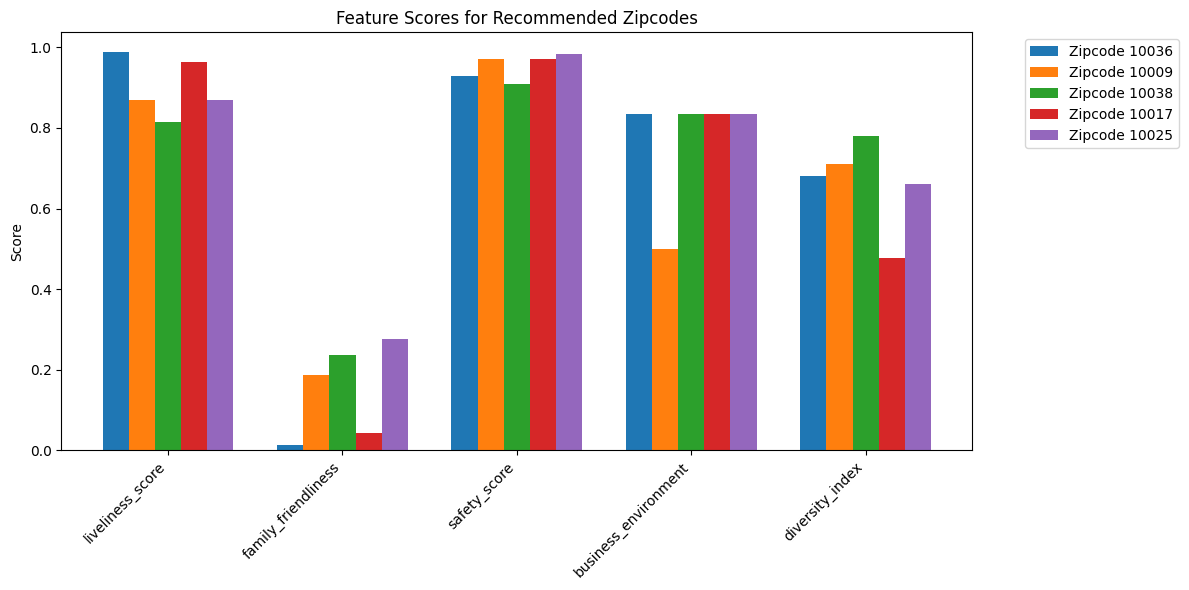

In [1044]:
if __name__ == "__main__":
    data = main()

In [1046]:
import json

data_json = data.to_dict(orient='records')

with open('processed_data_by_zipcode.json', 'w') as f:
    json.dump(data_json, f)

# After cleaning your property data
property_data_json = property_data.to_dict(orient='records')

with open('cleaned_property_data.json', 'w') as f:
    json.dump(property_data_json, f)

# KNN call if needed

In [1045]:
knn = joblib.load('knn_model.pkl')
knn_scaler = joblib.load('knn_scaler.pkl')
zipcode_order = joblib.load('zipcode_order.pkl')

def find_similar_zipcodes(data, preferred_zipcode, n_neighbors=5):
    features = ['LivelinessScore', 'FamilyFriendlinessScore', 'SafetyScore', 
                'BusinessEnvironmentScore', 'AmenityScore', 'DiversityIndex']
    
    preferred_zipcode_index = zipcode_order.index(preferred_zipcode)
    distances, indices = knn.kneighbors(knn_scaler.transform(data[features].iloc[preferred_zipcode_index].values.reshape(1, -1)))
    
    similar_zipcodes = [zipcode_order[i] for i in indices[0][1:]]  # Skip the first one as it's the zipcode itself
    return similar_zipcodes

FileNotFoundError: [Errno 2] No such file or directory: 'knn_model.pkl'